In [166]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
import os
import math

from source.utils import split_run_results, misc

# use colorblind color palette 
plt.style.use('tableau-colorblind10')


In [167]:
'''
    USER INPUT
'''

DO_SAVE = True
#run_names = ['resnet101_pr50_lcm0.0001_batch16', 'resnet101_pr75_lcm0.0001_batch16', 'resnet101_pr85_lcm0.0001_batch16'] # these logs dont have rx ip and port yet 
#run_names = ['resnet18_pr50_lcm0.0001_batch64', 'resnet18_pr75_lcm0.0001_batch64', 'resnet18_pr85_lcm0.0001_batch64'] # these logs dont have rx ip and port yet
#run_names = [ 'filter']
#run_names = ['cifar100-resnet101-kernel-np4-pr0.5-lcm1e-04-batch16', 'cifar100-resnet101-kernel-np4-pr0.85-lcm1e-04-batch16']
run_names = [f'esc-EscFusion-kernel-np4-pr{pr}-lcm1000' for pr in ["0.5", "0.7", "0.75", "0.8", "0.85"]]
num_runs = len(run_names)
test_name = run_names[0]
log_name = 'EscFusion'
num_nodes = 4

save_dir = os.path.join('assets', 'figs', test_name)
log_file_path = os.path.join('logs', test_name)

if DO_SAVE:
    os.makedirs(save_dir, exist_ok=True)

In [168]:
block_event_df, layer_event_df, total_runtime = split_run_results.combine_log_files(log_file_path, log_name, num_nodes)

In [169]:
# TODO: this is not grabbing the correct timing for some reason. Total execution time is printed at the end of execution in log file of final node 
for i, rt in enumerate(total_runtime):
    print(f'{run_names[i]} {rt}')

esc-EscFusion-kernel-np4-pr0.5-lcm1000 8.705360900028609
esc-EscFusion-kernel-np4-pr0.7-lcm1000 18.135251099942252
esc-EscFusion-kernel-np4-pr0.75-lcm1000 16.53822979994584
esc-EscFusion-kernel-np4-pr0.8-lcm1000 14.570981199969538


In [170]:
''' 
    Make block event timeline plot
'''
#block_event_df[block_event_df['node'] == 0][['type', 'timestamp','time','dur', 'type']].head(7)
block_event_df


,timestamp,time,node,layer,layer_name,type,dur,process_dur,bytes_tx,serialize_dur,encode_dur_tx,ip,port,bytes_rx,deserialize_time
62,2024-10-11 02:23:55.417861900,0.0000,1,0,NaN,receive,927.1381,NaN,NaN,NaN,NaN,NaN,NaN,21790858.0,120.5967
0,2024-10-11 02:23:56.349000000,931.1381,1,0,NaN,idle,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,2024-10-11 02:23:56.349476000,931.6141,1,1,conv1,execute,445.5240,13.6558,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,2024-10-11 02:23:56.362324500,944.4626,2,0,NaN,receive,1525.6755,NaN,NaN,NaN,NaN,NaN,NaN,21790858.0,132.8960
44,2024-10-11 02:23:56.794612000,1376.7501,1,1,NaN,total_send,4157.3880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42,2024-10-11 02:24:14.428183600,19010.3217,3,31,NaN,send,1.8164,NaN,42.0,0.0428,0.0015,127.0.0.1,5001.0,NaN,NaN
42,2024-10-11 02:24:14.428294700,19010.4328,2,31,NaN,send,0.7053,NaN,42.0,0.0625,0.0014,127.0.0.1,5001.0,NaN,NaN
87,2024-10-11 02:24:14.428841400,19010.9795,1,31,NaN,receive,0.1586,NaN,NaN,NaN,NaN,NaN,NaN,42.0,0.0357
88,2024-10-11 02:24:14.429979000,19012.1171,1,31,NaN,receive,0.0210,NaN,NaN,NaN,NaN,NaN,NaN,42.0,0.0300


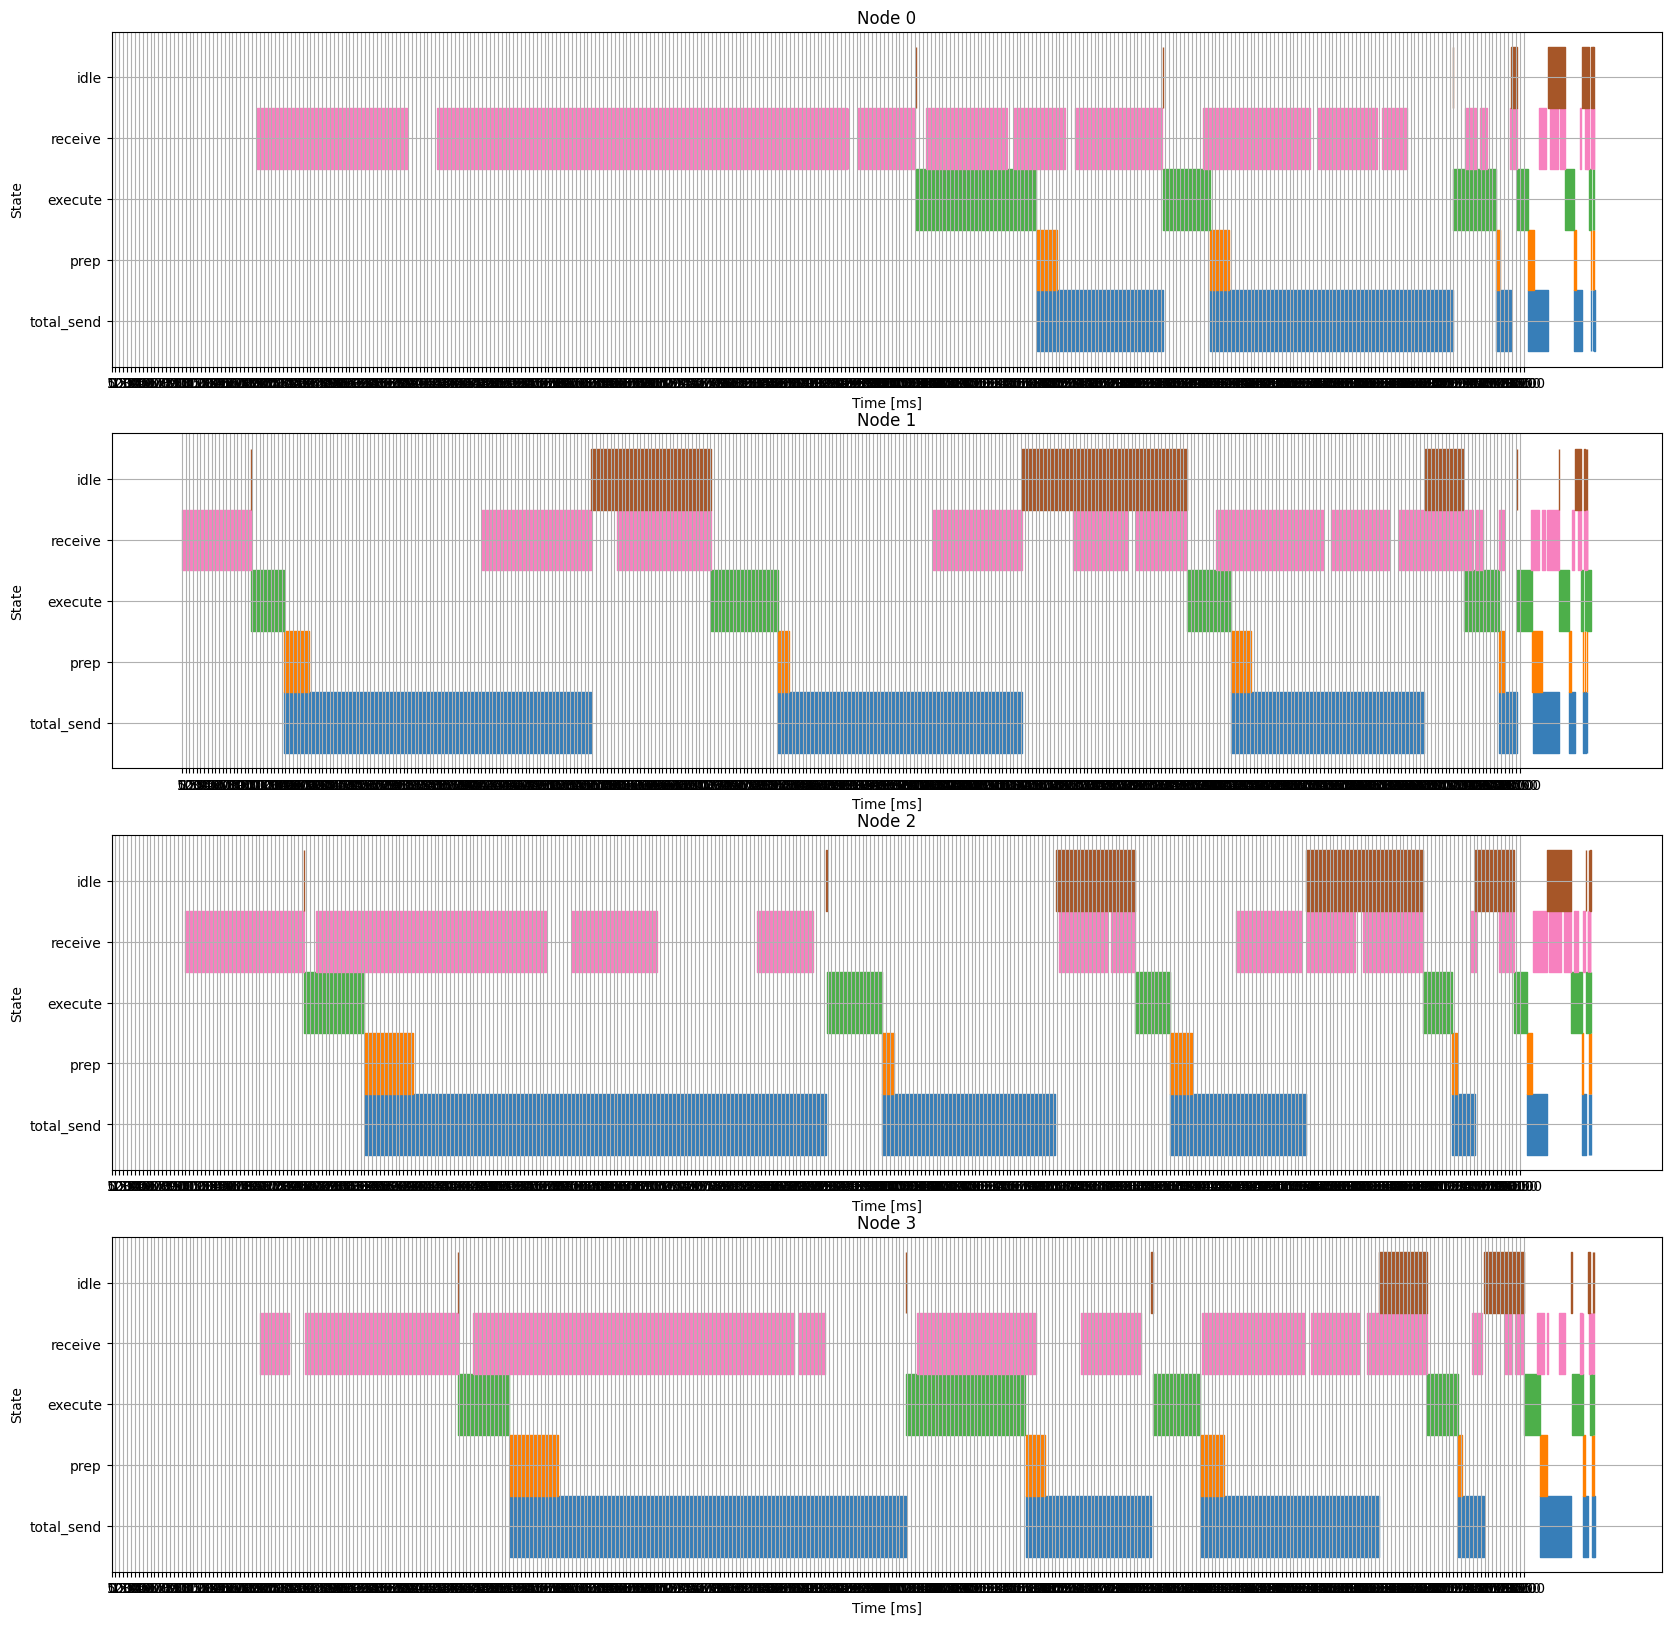

In [171]:
'''
    Plot timeline 
'''

def seq_of_tuples(df, col1, col2):
    return list(zip(df[col1], df[col2]))

# get layers that wait on inputs 
begin_block_layers = np.unique(block_event_df['layer'].to_numpy())

yheigth = 1
ystep = 1

comms_width = yheigth/num_nodes

fig, axs = plt.subplots(num_nodes, 1)
fig.set_size_inches(20,20)

# TODO: do for each node
inode = 0
state_types = ['total_send', 'prep','execute', 'receive', 'idle']
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
num_states = len(state_types)

for inode in range(num_nodes):
    axs[inode].grid()
    for istate in range(num_states):

        state_type = state_types[istate]

        # format data and plot
        bars = seq_of_tuples(block_event_df.loc[(block_event_df['node'] == inode) & (block_event_df['type'] == state_type)], 'time', 'dur')
        axs[inode].broken_barh(bars, (ystep*istate - yheigth/2,yheigth), color=CB_color_cycle[istate])


    title_str = f'Node {inode}'
    axs[inode].set_title(title_str)
    axs[inode].set_xlabel('Time [ms]')
    axs[inode].set_ylabel('State')
    axs[inode].set_yticks(ticks=range(0, num_states*ystep, ystep), labels=state_types)

    xlim_range = []#[0, 200] #[700, 800]
    step_size = 50

    if [] == xlim_range:
        axs[inode].set_xticks(range(0, math.ceil(max(total_runtime)*1e3), step_size))
    else:
        axs[inode].set_xlim(xlim_range)
        axs[inode].set_xticks(range(xlim_range[0], xlim_range[1], step_size))
    
    #plt.legend(state_types)
    #plt.xlim(0,max(total_runtime)*1.1)

#fig.show()
#plt.ion()
#_ = plt.show()
    

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'block_execution_time.jpg'))




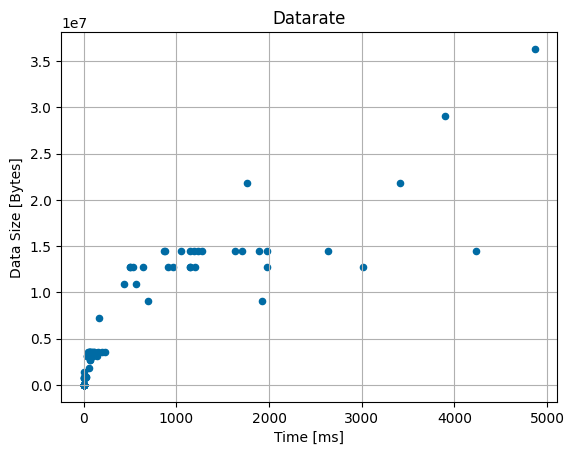

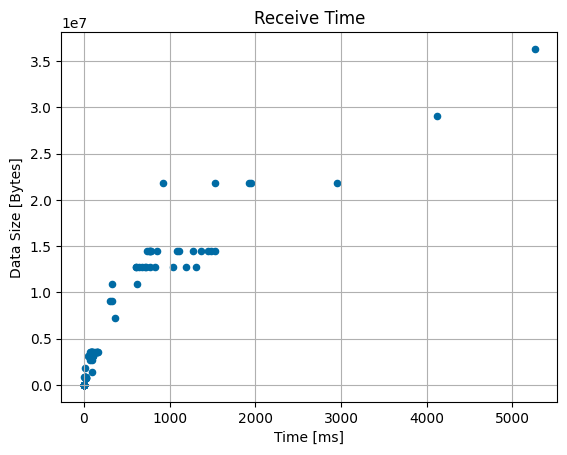

In [172]:
'''
    Make scatter plots for TX and RX
'''

ax_send = block_event_df[block_event_df['type'] == 'send'].plot.scatter(x='dur', y='bytes_tx')
ax_send.set_xlabel('Time [ms]')
ax_send.set_ylabel('Data Size [Bytes]')
ax_send.set_title('Datarate')
ax_send.grid()

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'datarate_send.jpg'))

# TODO: fix the measurment of time in debugger logging
ax_receive = block_event_df[block_event_df['type'] == 'receive'].plot.scatter(x='dur', y='bytes_rx')
ax_receive.set_xlabel('Time [ms]')
ax_receive.set_ylabel('Data Size [Bytes]')
ax_receive.set_title('Receive Time')
ax_receive.grid()

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'datarate_receive.jpg'))




In [173]:
'''
    Breakdown of total time spent in different states
'''

def sum_dur(df, type, node):
    mask = (df['type'] == type) & (df['node'] == node)
    return sum(df['dur'].loc[mask])

for i in range(num_nodes):
    total_idle_time = sum_dur(block_event_df, 'idle', i)
    total_process_time = sum_dur(block_event_df, 'process_dur', i)
    total_exec_time = sum_dur(block_event_df, 'execute', i)
    total_tx_time = sum_dur(block_event_df, 'send', i)
    total_prep_time = sum_dur(block_event_df, 'prep', i)
    total_rx_time = sum_dur(block_event_df, 'receive', i)
    timed_total_time = total_runtime[i]

    percent_idle = total_idle_time/total_runtime[i]*100/1e3
    percent_process_time = total_process_time/total_runtime[i]*100/1e3
    percent_exec_time = total_exec_time/total_runtime[i]*100/1e3
    percent_tx_time = total_tx_time/total_idle_time*100/1e3 # overlap in idle time and tx time
    percent_prep_time = total_prep_time/total_runtime[i]*100/1e3
    percent_rx_time = total_rx_time/total_idle_time*100
    percent_total_time =timed_total_time/total_runtime[i]*100/1e3

    data = {
            'States': ["IDLE", "CHECK IN (IDLE)", "TX (IDLE)", "RX (IDLE)", "EXECUTING", "PREP", "Total"], 
            'Time [ms]':[total_idle_time, total_process_time, total_tx_time, total_rx_time, total_exec_time, total_prep_time, timed_total_time],
            'Percent [%]':[percent_idle, percent_process_time, percent_tx_time, percent_rx_time, percent_exec_time, percent_prep_time, percent_total_time], 
            }
    df = pd.DataFrame(data)
    print(f'Node {i}')
    print(f'Run time {total_runtime[i]}s')
    print(df)
    print()


Node 0
Run time 8.705360900028609s
            States     Time [ms]  Percent [%]
0             IDLE    403.870900     4.639336
1  CHECK IN (IDLE)      0.000000     0.000000
2        TX (IDLE)   7860.448499     1.946278
3        RX (IDLE)  13801.662600  3417.345147
4        EXECUTING   2996.374000    34.419871
5             PREP    652.174400     7.491641
6            Total      8.705361     0.100000

Node 1
Run time 18.135251099942252s
            States     Time [ms]  Percent [%]
0             IDLE   4493.355800    24.776915
1  CHECK IN (IDLE)      0.000000     0.000000
2        TX (IDLE)  15650.361000     0.348300
3        RX (IDLE)  10007.887800   222.726360
4        EXECUTING   2858.567500    15.762492
5             PREP    974.422300     5.373084
6            Total     18.135251     0.100000

Node 2
Run time 16.53822979994584s
            States    Time [ms]  Percent [%]
0             IDLE   3361.54780    20.325923
1  CHECK IN (IDLE)      0.00000     0.000000
2        TX (IDLE)  1

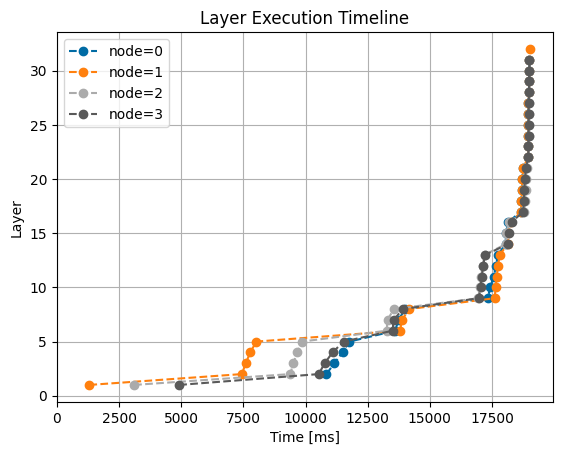

In [174]:
'''
    Look at layer execution times
'''

plt.figure()
plt.grid()
legend_strs = []
for i in range(4):
    plt.plot(layer_event_df[layer_event_df['node'] == i]['time'] ,layer_event_df[layer_event_df['node'] == i]['layer'], '--o')
    legend_strs += [f'node={i}']
plt.title('Layer Execution Timeline')
plt.xlabel('Time [ms]')
plt.ylabel('Layer')
plt.legend(legend_strs)
#_ = plt.xticks(np.arange(0, 10, step=1))
plt.xlim(0,max(total_runtime)*1.1*1e3)

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'layer_execution_time.jpg'))



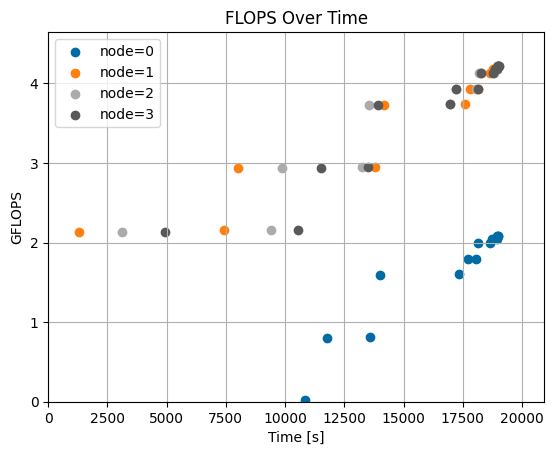

In [175]:

plt.figure()
plt.grid()
legend_strs = []
max_cum_bytes = 0
for i in range(num_nodes):

    tmp_merged_layer_df = layer_event_df[layer_event_df['node'] == i]
    nan_mask = tmp_merged_layer_df['FLOPS'].isna() == 0
    cum_bytes = np.cumsum(tmp_merged_layer_df[nan_mask]['FLOPS'].to_numpy())
    plt.scatter(tmp_merged_layer_df[nan_mask]['time'] ,cum_bytes/1e9)

    if max_cum_bytes < cum_bytes[-1]:
        max_cum_bytes = cum_bytes[-1]/1e9

    legend_strs += [f'node={i}']
plt.title('FLOPS Over Time')
plt.xlabel('Time [s]')
plt.ylabel('GFLOPS')
_ = plt.legend(legend_strs)
plt.xlim(0, max(layer_event_df['time'])*1.1)
plt.ylim(0,max_cum_bytes*1.1)
#_ = plt.xticks(np.arange(0, 250, step=20))

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'FLOPS.jpg'))


In [176]:
layer_event_df['FLOPS']

4     2.135491e+09
3     2.135491e+09
3     2.135491e+09
2     2.179072e+07
26             NaN
          ...     
28             NaN
28             NaN
24    4.064000e+03
24    4.064000e+03
0              NaN
Name: FLOPS, Length: 124, dtype: float64

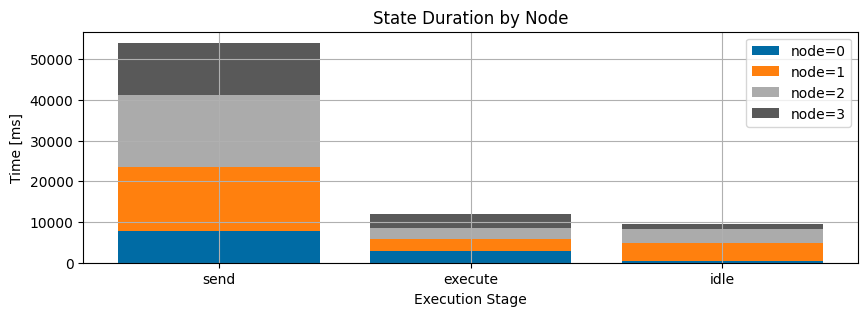

In [177]:
'''
    WIP Compare durations from different states 

'''

stages = ["send", "execute", "idle"]
num_stages = len(stages)
legend_strs = []

plt.figure(figsize=(10,3))
plt.grid()
bot = np.zeros(num_stages)
for inode in range(4):

    stages_array = np.array([])
    for a_stage in stages:
        stages_array = np.append(stages_array, block_event_df[(block_event_df['node'] == inode) & (block_event_df['type'] == a_stage) ]['dur'].sum(axis=0))
    plt.bar(stages, stages_array, bottom=bot)
    bot += stages_array

    legend_strs += [f'node={inode}']

plt.title(f'State Duration by Node')
plt.xlabel('Execution Stage')
plt.ylabel('Time [ms]')
plt.legend(legend_strs)

#_ = plt.xticks(layer_array*17.6, uniq_layers)
#plt.ylim(0, 50)

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, f'state_dur_compare_node-{test_name}.jpg'))

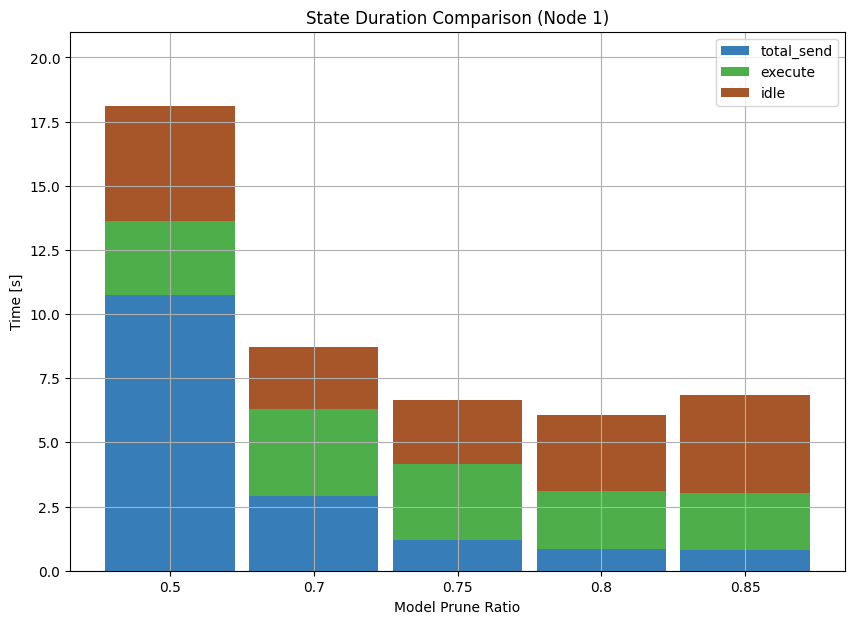

In [178]:
'''
    WIP Compare runtimes from different runs 

    # TODO: put bars next to one another 

'''

 
CB_color_cycle_short = ['#377eb8', '#4daf4a', '#a65628']
stages = ['total_send','execute', 'idle']
num_stages = len(stages)

# ticks 
legend_strs = []

width = 0.9

# make plot 
plt.figure(figsize=(10,7))
plt.grid()

# iterators
inode = 1
data_frames = []
model_names= []
bottom = np.zeros(num_runs)

# get df for each run 
for irun in range(num_runs):
    run_name = run_names[irun]
    data_frames.append( split_run_results.combine_log_files(os.path.join('logs', run_name), log_name, num_nodes)[0] )

    # get params (assume runname is the same as model name)
    model_params = misc.parse_filename(run_names[irun]+'.pt')

    prune_ratio = model_params['pr']
    lcm = model_params['lcm']

    if prune_ratio == 0:
        model_names.append('Dense')
    else:
        model_names.append(f'{prune_ratio}')


# plot 1 stage at a time 
istage = 0
for a_stage in stages:

    # fill array with value for each run 
    stages_array = np.array([])
    for irun in range(num_runs):
        master_tmp = data_frames[irun] 
        stages_array = np.append(stages_array, master_tmp[(master_tmp['type'] == a_stage) & (master_tmp['node']==inode)]['dur'].sum(axis=0))

    # plot 
    plt.bar(model_names, stages_array/1e3, width=width, align='center', bottom=bottom/1e3, color=CB_color_cycle_short[istage])

    # increase counters
    bottom += stages_array
    istage += 1
    irun += 1

#ax = plt.gca()
#ax.set_yscale('log')

# labels
plt.title(f'State Duration Comparison (Node {inode})')
plt.xlabel('Model Prune Ratio')
plt.ylabel('Time [s]')
plt.legend(stages)

xlim_range = [0, 21]#[0, 200] #[700, 800]

if not [] == xlim_range:
    plt.ylim(xlim_range)

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'state_dur_compare_stacked.jpg'))

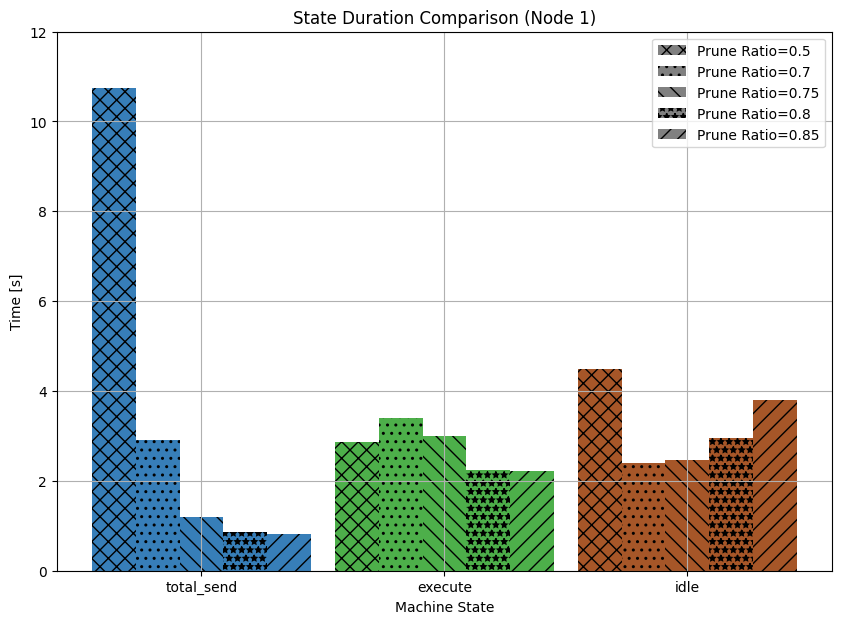

In [179]:
'''
    WIP Compare runtimes from different runs 

    # TODO: put bars next to one another 

'''
 
CB_color_cycle_short = ['#377eb8', '#4daf4a', '#a65628']
hatch_list = ["xx", "..", "\\\\", "**", '//', '++']
stages = ['total_send','execute', 'idle']
num_stages = len(stages)

# ticks 
width = 0.9
stage_values = np.arange(num_stages)*num_runs
run_values = np.arange(num_runs)*width
legend_strs = []

# make plot 
plt.figure(figsize=(10,7))
plt.grid()

# iterators
inode = 1
data_frames = []
model_names= []
bottom = np.zeros(num_runs)

# get df for each run 
for irun in range(num_runs):
    run_name = run_names[irun]
    data_frames.append( split_run_results.combine_log_files(os.path.join('logs', run_name), log_name, num_nodes)[0] )

    # get params (assume runname is the same as model name)
    model_params = misc.parse_filename(run_names[irun]+'.pt')

    prune_ratio = model_params['pr']
    lcm = model_params['lcm']

    if prune_ratio == 0:
        model_names.append('Dense')
    else:
        model_names.append(f'Prune Ratio={prune_ratio}')

    # make dummy bar for legend 
    plt.bar(0, 0, color="gray",  hatch= hatch_list[irun])

# plot 1 stage at a time 
istage = 0
for a_stage in stages:

    # fill array with value for each run 
    stages_array = np.array([])
    for irun in range(num_runs):
        master_tmp = data_frames[irun] 
        stage_time = master_tmp[(master_tmp['type'] == a_stage) & (master_tmp['node']==inode)]['dur'].sum(axis=0)

        # plot 
        plt.bar(stage_values[istage] + run_values[irun]  -width*num_runs/2 + width/2,
                    stage_time/1e3,
                    width=width,
                    align='center', 
                    color=CB_color_cycle_short[istage], 
                    hatch= hatch_list[irun])

    # increase counters
    istage += 1
    irun += 1

# labels
plt.xticks(stage_values, stages)
plt.title(f'State Duration Comparison (Node {inode})')
plt.xlabel('Machine State')
plt.ylabel('Time [s]')
plt.legend(model_names)

#_ = plt.xticks(layer_array*17.6, uniq_layers)
plt.ylim(0, 12)

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'state_dur_compare.jpg'))